## PLAN

### 1/ La récupération de données: 

### 2/ Nettoyage des données
lire les définitions des variables
trouver une aidée d'application
filtrer votre jeu de données
traiter les valeurs aberrantes (méthode interquartile comme Ex), no confondez pas avec valeur aberrante et valeur atypique
traiter les valeurs manquantes (1 _remplacer les par 0, la moyenne, ou la médiane, 2_ estimer les valeurs manquantes ==> algorithme de KNN, ou fonction "IterativeIputer pour les variables corrélées entre elles")

### 3/ Exploration des données (trouver les bons indicateurs)
analyse univariées Ex : fonction "describe"
analyse bivariées 
analyse multivariées (analyse en composantes principales "ACP" et une analyse explicative avec l'ANOVA)
### 4/ Présentation de l'aidée d'application






ctégorie du produit
la valeur nutritionnelle
le nombre d’additifs ;
des produits plus sains

la variable la plus importante "nutrition score"
classer les par pays par catégorie et par mot clès


#  Importation de packages et définition de fonctions

In [1]:
# Impotation librairies
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#visualiser l'ensemble du dataframe, toutes les lignes et colonnes.Faire apparaitre l'ensemble des informations.
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_column", 180)
pd.set_option("display.max_colwidth", 15)


In [3]:
#********************************** Calcule des valeurs nulles + pourcentage: ******************************
def calc_inf (df,line):
    
    # ****************** Définition des variabes************************************************************
    nb_line_nan = nb_line_mix = nb_line_ssna= nb_col_nan = nb_col_mix = nb_col_ssna = 0   
         
    #***************************************************** Les statistiques NaN par colonne*****************
    
    n_list = df.isnull().sum().tolist()
    for i in range(len(n_list)):
        if n_list[i] == 0:                     # Nombre de colonnes sans NaN
            nb_col_ssna += 1  
        elif n_list[i] == len(df):             # Nombre de colonnes nulles
            nb_col_nan += 1
        elif 0 < n_list[i] < len(df):          # Nombre de colonnes mixtes
            nb_col_mix += 1
    print("* Nombre de colonnes sans NaN -------:",nb_col_ssna)
    print("* Nombre de colonnes NaN ------------:", nb_col_nan)
    print("* Nombre de colonnes mixtes----------:",nb_col_mix)
   # *************************************** Les statistiques NaN par ligne ********************************

    if line == True:
        for j in range(len(df.index)) :
            if df.iloc[j].isnull().sum() == len(df.columns):         # Nombre de lignes nulles
                nb_line_nan += 1
            elif 0 < df.iloc[j].isnull().sum() < len(df.columns):    # Nombre de lignes mixtes
                nb_line_mix += 1
            elif df.iloc[j].isnull().sum() == 0:                     # Nombre de lignes sans NaN
                nb_line_ssna += 1
        print("* Nombre de ligne entièrement nulles :",nb_line_nan)  
        print("* Nombre de ligne mixtes ----------- :", nb_line_mix) 
        print("* Nombre de ligne sans NaN ----------:", nb_line_ssna)
    #*******************************************************************************************************
    nb_line = df.index.size
    nb_colonne = df.columns.size
    tot = (nb_colonne*nb_line)
    nan = df.isnull().sum().sum()
    nan_prcnt = (100 * nan) / tot
    not_nan = df.notna().sum().sum()
    not_nan_prcnt = float((100 * not_nan) / tot)
    #*******************************************************************************************************
    
    print("* Nombre de lignes -----------------------: {:.0f}".format(nb_line))
    print("* Nombre de colonnes ---------------------: {:.0f}".format(nb_colonne))
    print("* Nombre de cases ------------------------: {:.0f}".format(tot))
    print("* Nombre de valeurs nulles ---------------: {:.0f}".format(nan))
    print("* Nombre de valeurs non nulles -----------: {:.0f}".format(not_nan))
    print("* le pourcentage des valeurs nulles ------:",str("%.1f" % nan_prcnt) + ' %')
    print("* le pourcentage des valeurs non nulles --:",str("%.1f" % not_nan_prcnt) + ' %')
    #a = pd.concat([not_nan_prcnt,nan_prcnt])
    # *******************************************************************************************************
    
    t= [not_nan_prcnt, nan_prcnt]
    plt.pie(t, labels = ['Valeurs non nulles', 
                         'Valeurs nulles (NaN)'],colors =['c', 'r'],
            startangle = 90, shadow = True, explode =(0,0.1),
            autopct = "%1.1f%%", normalize = True)
    plt.title("Le taux de remplissage en %")
    plt.show()

In [4]:
#************************************ Valeurs manquantes et pourcentage en tableau % **************************************

def mssng_val(df):
    mssng_t = pd.DataFrame(columns=['Variable_name', 'Missing_values', 'Missing_rate'])
    mssng_t['Variable_name'] = df.columns
    
    missing = list()
    percentage_missing = list()
    
    for col in df.columns:
        nb_missing = df[col].isna().sum()                  # le nombre des valeurs NaN par colonne
        pc_missing = df[col].isna().sum()/df[col].size     # le pourcentage des valeurs NaN par colonne
        
        missing.append(nb_missing)
        percentage_missing.append(pc_missing)
        
    mssng_t['Missing_values'] = list(missing)
    mssng_t['Missing_rate'] = list(percentage_missing)
    mssng_t = mssng_t.sort_values(by= ['Missing_values'], ascending = False)
    return mssng_t

In [5]:
def comp_val(df):
    comp_t = pd.DataFrame(columns=['Variable_name', 'completation_values', 'completation_rate'])
    comp_t['Variable_name'] = df.columns
    
    completation = list()
    percentage_completation = list()
    
    for col in df.columns:
        nb_completation = df[col].notna().sum()                 # le nombre des valeurs non NaN par colonne
        pc_completation = (df[col].notna().sum()/df[col].size)*100     # le pourcentage des valeurs non NaN par colonne
        
        completation.append(nb_completation)
        percentage_completation.append(pc_completation)
        
    comp_t['completation_values'] = list(completation)
    comp_t['completation_rate'] = list(percentage_completation)
    comp_t = comp_t.sort_values(by= ['completation_values'], ascending = False)
    return comp_t

In [6]:
#*********************************** Choix interquartile ****************************************
def flt_nan(df, seuil):
    df_flt = df.copy()
    for col in df.columns:
        x = (df[col].isna().sum()/df.shape[0])*100 # df.shape[0] ==> index, df.shape[1] ==> columns
        if x >= seuil:
            df_flt = df_flt.drop(columns= col)
  
    #data_set["not_na"].plot(kind ='bar',color = "red", figsize = (15, 5))
    #plt.title('Présentation des colonnes en-dessus de 20% de Nan', size=20)
    
    #data_set["not_na"].plot(kind ='bar', figsize = (15, 5))
    #plt.title('Présentation des valeurs non_na et Nan par variable', size=15)
    return df_flt

In [7]:
def pie_pc(df):
    nb_line = df.index.size
    nb_colonne = df.columns.size
    tot = (nb_colonne*nb_line)
    nan_prcnt = float((100 * df.isnull().sum().sum()) / tot)
    not_nan_prcnt = float((100 * df.notna().sum().sum()) / tot)
    t= [not_nan_prcnt,nan_prcnt]
    plt.pie(t, labels = ['Valeurs non nulles', 'Valeurs nulles (NaN)'],colors =['c', 'r'],
    startangle = 90, shadow = True, explode =(0,0.1), autopct = "%1.1f%%", normalize = True)
    plt.title("Le taux de remplissage en %")
    plt.show()

# 1/ La récupération de données: 

In [8]:
prd = pd.read_csv("D:\Projet Classrooms\Projet_3\products.csv", sep = '\t', low_memory=False)
prd_orgn = prd.copy()

In [9]:
prd

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://worl...,openfoodfac...,1474103866,2016-09-17T...,1474103893,2016-09-17T...,Farine de b...,NaN,1kg,NaN,NaN,Ferme t'y R...,ferme-t-y-r...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://worl...,usda-ndb-im...,1489069957,2017-03-09T...,1489069957,2017-03-09T...,Banana Chip...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-s...,États-Unis,"Bananas, ve...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas ...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,d,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,2243.0,NaN,28.57,28.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.018,64.29,14.29,NaN,NaN,

In [10]:
prd.shape

(320772, 162)

# 2/ Nettoyage des données
****
     * liste
        * Lire les définitions des variables >>> OK
        * Trouver une aidée d'application >>> OK >>> la valeur nutritionnelle et classement des produits les plus sains
        * Filtrer votre jeu de données >>>> OK
        * Traiter les valeurs aberrantes (méthode interquartile comme Ex), no confondez pas avec valeur aberrante et valeur atypique>>>>> On peut repérer les valeurs aberrantes en utilisant les boîtes à moustache >>>> OK
        * Traiter les valeurs manquantes (
            * 1 _Remplacer les par 0, la moyenne, ou la médiane, OK
            * 2_ Estimer les valeurs manquantes ==> algorithme de KNN, ou fonction "IterativeIputer pour les variables corrélées entre elles")
    
****

* Nombre de colonnes sans NaN -------: 2
* Nombre de colonnes NaN ------------: 16
* Nombre de colonnes mixtes----------: 144
* Nombre de lignes -----------------------: 320772
* Nombre de colonnes ---------------------: 162
* Nombre de cases ------------------------: 51965064
* Nombre de valeurs nulles ---------------: 39608589
* Nombre de valeurs non nulles -----------: 12356475
* le pourcentage des valeurs nulles ------: 76.2 %
* le pourcentage des valeurs non nulles --: 23.8 %


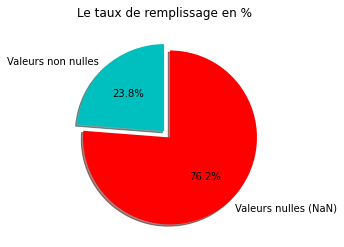

In [11]:
calc_inf(prd, False)

In [12]:
nan_org = mssng_val(prd) # mettre en tableau les valeurs manquantes et le ratio en %
nan_org

,Variable_name,Missing_values,Missing_rate
161,water-hardn...,320772,1.000000
41,no_nutriments,320772,1.000000
50,ingredients...,320772,1.000000
52,nutrition_g...,320772,1.000000
98,nervonic-ac...,320772,1.000000
97,erucic-acid...,320772,1.000000
96,mead-acid_100g,320772,1.000000
94,elaidic-aci...,320772,1.000000
67,butyric-aci...,320772,1.000000
68,caproic-aci...,320772,1.000000


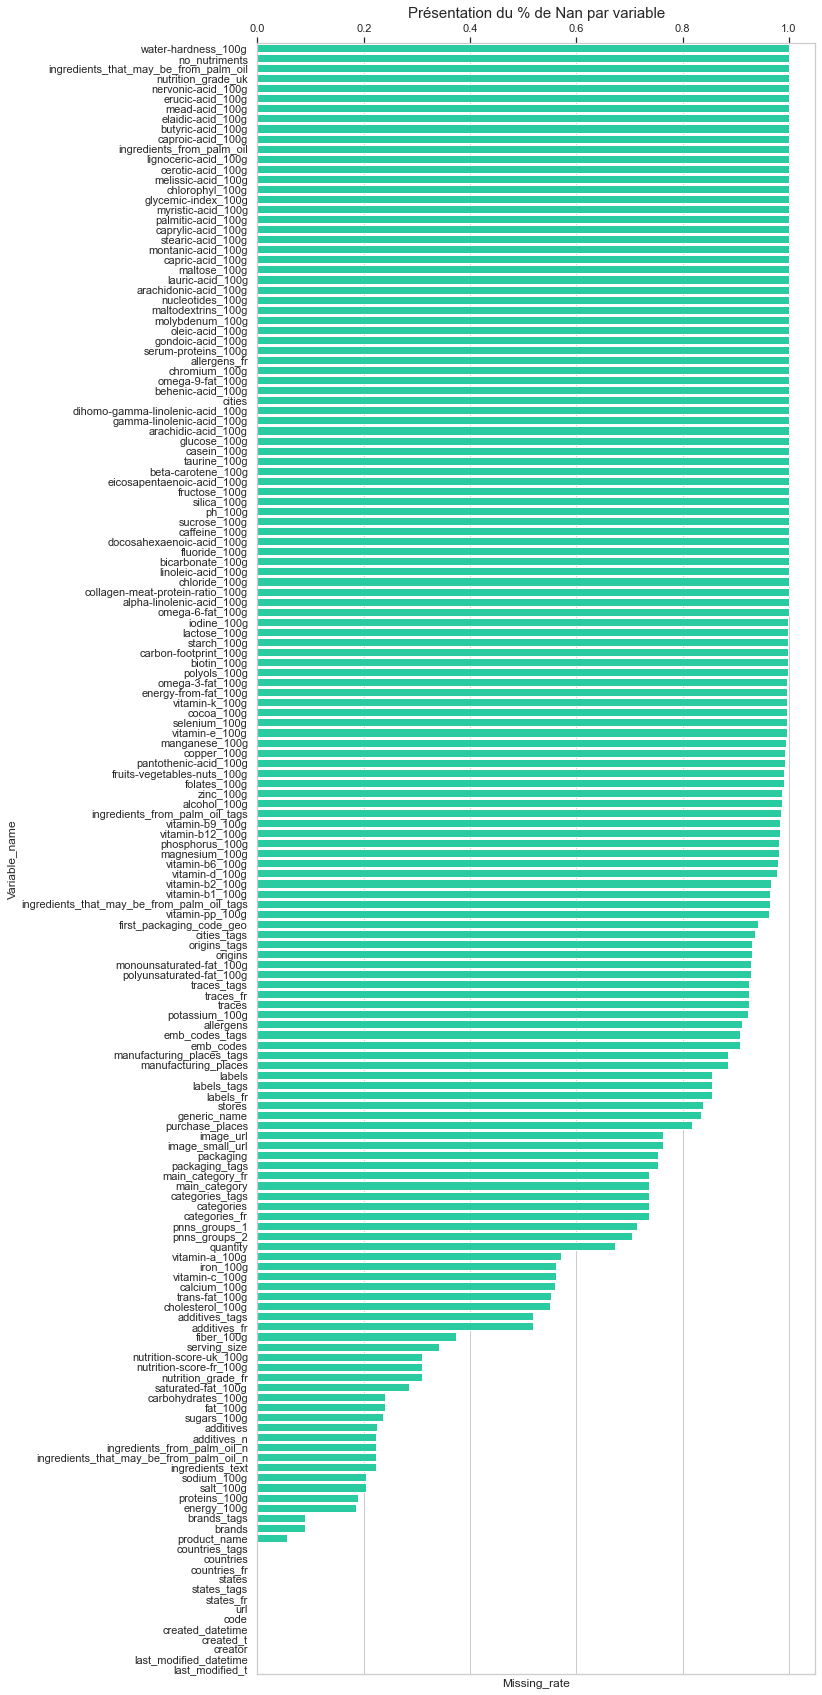

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 30))
ax = sns.barplot(x = nan_org['Missing_rate'], y = nan_org['Variable_name'], orient = 'h',color = '#11E5AD' )
ax.xaxis.set_ticks_position('top')
plt.title('Présentation du % de Nan par variable', size=15)
plt.show()

C:\Users\Win\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


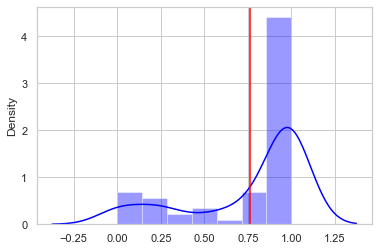

In [14]:
dis_nan_org = nan_org['Missing_rate'].values
sns.distplot(dis_nan_org, color= 'blue', kde=True)
mean = nan_org['Missing_rate'].mean()
plt.axvline(mean, 0, 1, color='red')
plt.show()

In [15]:
compl = comp_val(prd)

In [16]:
compl

,Variable_name,completation_values,completation_rate
5,last_modifi...,320772,100.000000
6,last_modifi...,320772,100.000000
2,creator,320770,99.999377
3,created_t,320769,99.999065
4,created_dat...,320763,99.997194
0,code,320749,99.992830
1,url,320749,99.992830
58,states_fr,320726,99.985660
57,states_tags,320726,99.985660
56,states,320726,99.985660


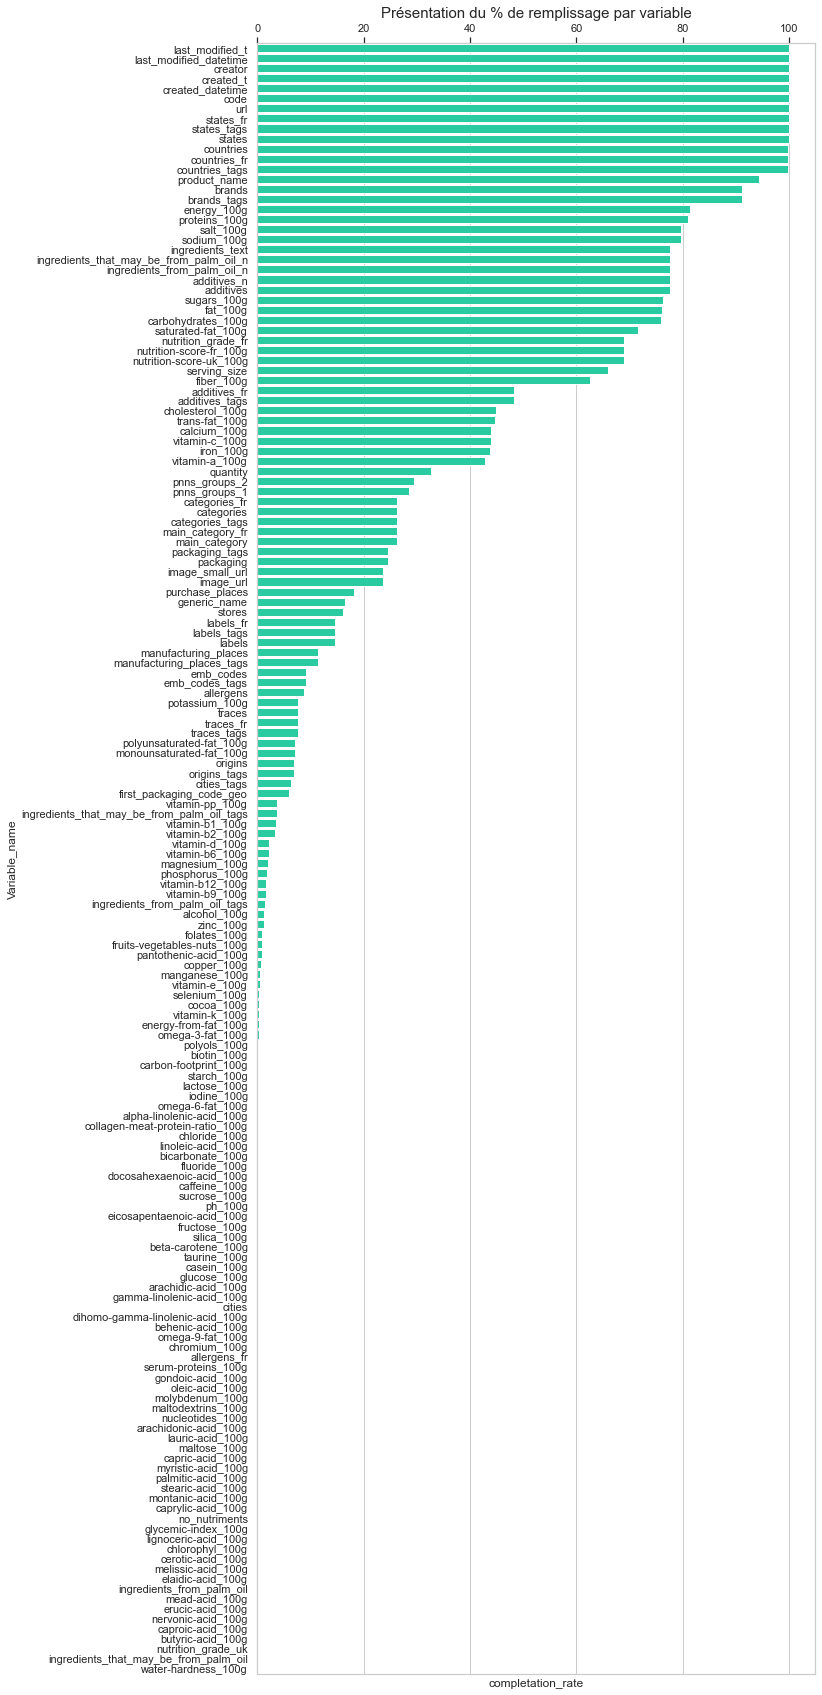

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 30))
ax = sns.barplot(x = compl['completation_rate'], y = compl['Variable_name'], orient = 'h',color = '#11E5AD' )
ax.xaxis.set_ticks_position('top')
plt.title('Présentation du % de remplissage par variable', size=15)
plt.show()

In [18]:
prd_flt = flt_nan(prd, 80) # Suppréssion des colonnes qui contiennent de 80% de NaN
prd_flt.shape

(320772, 54)

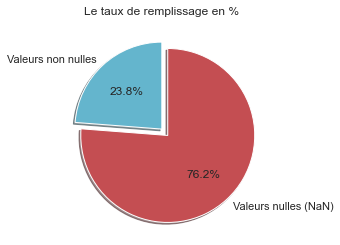

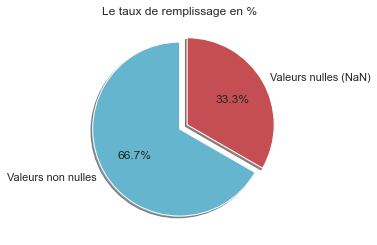

(None, None)

In [19]:
pie_pc(prd), pie_pc(prd_flt)  # Présentation du "prd" avant et après le premier filtrage

In [20]:
prd_flt

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,countries,countries_tags,countries_fr,ingredients_text,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://worl...,openfoodfac...,1474103866,2016-09-17T...,1474103893,2016-09-17T...,Farine de b...,1kg,NaN,NaN,Ferme t'y R...,ferme-t-y-r...,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://worl...,usda-ndb-im...,1489069957,2017-03-09T...,1489069957,2017-03-09T...,Banana Chip...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-s...,États-Unis,"Bananas, ve...",28 g (1 ONZ),0.0,[ bananas ...,NaN,NaN,0.0,0.0,d,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://worl...,usda-ndb-im...,1489069957,2017-03-09T...,1489069957,2017-03-09T...,Peanuts,NaN,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,NaN,US,en:united-s...,États-Unis,"Peanuts, wh...",28 g (0.25 ...,0.0,[ peanuts ...,NaN,NaN,0.0,0.0,b,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
3,0000000016087,http://worl...,usda-ndb-im...,1489055731,2017-03-09T...,1489055731,2017-03-09T...,Organic Sal...,NaN,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,NaN,US,en:united-s...,États-Unis,Organic haz...,28 g (0.25 ...,0.0,[ organic-...,NaN,NaN,0.0,0.0,d,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,2540.0,57.14,5.36,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://worl...,usda-ndb-im...,1489055653,2017-03-09T...,1489055653,2017-03-09T...,Organic Pol...,NaN,NaN,NaN,Bob's Red Mill,bob-s-red-mill,NaN,NaN,NaN,US,en:united-s...,États-Unis,Organic pol...,35 g (0.25 ...,0.0,[ organic-...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,1552.0,1.43,NaN,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320767,9948282780603,http://worl...,openfoodfac...,1490631299,2017-03-27T...,1491244498,2017-04-03T...,Tomato & ri...,1,Plastique,plastique,Panzani,panzani,NaN,NaN,NaN,en:RO,en:romania,Roumanie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,99567453,http://worl...,usda-ndb-im...,1489059076,2017-03-09T...,1491244499,2017-04-03T...,Mint Melang...,NaN,Plastique,plastique,Trader Joe's,trader-joe-s,NaN,NaN,NaN,US,en:united-s...,États-Unis,Organic pep...,20 g (0.7 oz),0.0,[ organic-...,NaN,NaN,0.0,0.0,b,NaN,NaN,en:to-be-co...,en:to-be-co...,A compléter...,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.000,0.00,0.00,0.0,0.00,0.00000,0.000,0.0,0.0000,0.000,0.00000,0.0,0.0
320769,9970229501521,http://worl...,tomato,1422099377,2015-01-24T...,1491244499,2017-04-03T...,乐吧泡菜味薯片,50 g,Plastique,plastique,乐吧,乐吧,Potato chips,en:salty-sn...,Snacks salé...,China,en:china,Chine,NaN,NaN,NaN,

In [21]:
tab_nan = mssng_val(prd_flt)  
tab_nan

,Variable_name,Missing_values,Missing_rate
35,image_url,244936,0.763583
36,image_small...,244936,0.763583
9,packaging,241812,0.753844
10,packaging_tags,241811,0.753841
34,main_catego...,236406,0.736991
33,main_category,236406,0.736991
14,categories_...,236383,0.736919
13,categories,236362,0.736854
15,categories_fr,236361,0.736850
28,pnns_groups_1,229259,0.714710


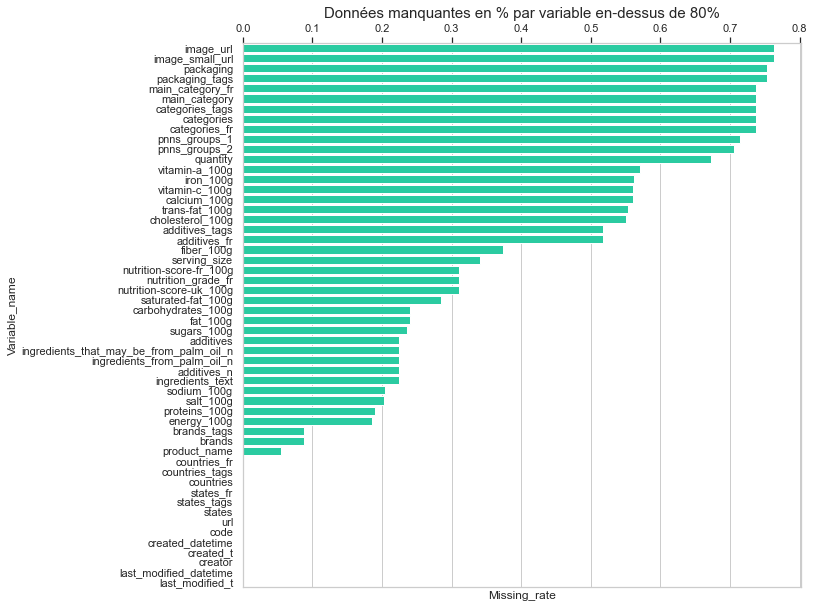

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))
ax = sns.barplot(x = tab_nan['Missing_rate'], y = tab_nan['Variable_name'], orient = 'h',color = '#11E5AD' )
ax.xaxis.set_ticks_position('top')
plt.title('Données manquantes en % par variable en-dessus de 80%', size=15)
plt.show()

C:\Users\Win\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


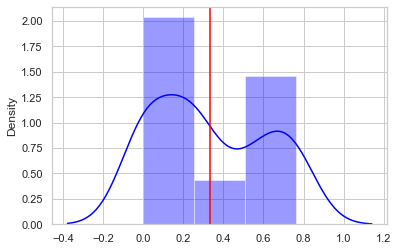

In [23]:
dis_nan = tab_nan['Missing_rate'].values
sns.distplot(dis_nan, color= 'blue', kde=True)
mean = tab_nan['Missing_rate'].mean()
plt.axvline(mean, 0, 1, color='red')
plt.show()

In [24]:
prd_flt.dtypes

code                                        object
url                                         object
creator                                     object
created_t                                   object
created_datetime                            object
last_modified_t                             object
last_modified_datetime                      object
product_name                                object
quantity                                    object
packaging                                   object
packaging_tags                              object
brands                                      object
brands_tags                                 object
categories                                  object
categories_tags                             object
categories_fr                               object
countries                                   object
countries_tags                              object
countries_fr                                object
ingredients_text               

In [25]:
prd_flt.shape

(320772, 54)

### 1) Filtrage métier : garder que les colonnes utiles pour l’application (max 10 colonnes)
****
     * Après le premier filtrage, maintenant on doit garder que les variables qui nous intéressent pour notre application, en dessous la liste des variavles potentielles
****

In [26]:
list_food_facts = ['code',  
                     'creator',
                     'created_datetime', 
                     'product_name', 
                     'brands',
                     'countries_fr', 
                     'nutrition_grade_fr',
                     'pnns_groups_1', 
                     'pnns_groups_2', 
                     'energy_100g', 
                     'fat_100g', 
                     'saturated-fat_100g',
                     'cholesterol_100g', 
                     'carbohydrates_100g', 
                     'sugars_100g', 
                     'fiber_100g',
                     'proteins_100g', 
                     'salt_100g',
                     'nutrition-score-fr_100g']

In [27]:
food_facts = prd_flt[list_food_facts]
food_facts.shape

(320772, 19)

In [28]:
food_facts[list_food_facts].isna().sum().sum()

1504575

In [29]:
food_facts[list_food_facts].notna().sum()

code                       320749
creator                    320770
created_datetime           320763
product_name               303010
brands                     292360
countries_fr               320492
nutrition_grade_fr         221210
pnns_groups_1               91513
pnns_groups_2               94491
energy_100g                261113
fat_100g                   243891
saturated-fat_100g         229554
cholesterol_100g           144090
carbohydrates_100g         243588
sugars_100g                244971
fiber_100g                 200886
proteins_100g              259922
salt_100g                  255510
nutrition-score-fr_100g    221210
dtype: int64

In [30]:
slct_ingr = ['energy_100g',
            'fat_100g',
            'saturated-fat_100g',
            'cholesterol_100g',
            'carbohydrates_100g',
            'sugars_100g', 
            'fiber_100g',
            'proteins_100g',
            'salt_100g']

In [31]:
slct_ingr_1 = ['energy_100g',
            'fat_100g',
            'saturated-fat_100g',
            'cholesterol_100g',
            'carbohydrates_100g',
            'sugars_100g', 
            'fiber_100g',
            'proteins_100g',
            'salt_100g',
            'nutrition-score-fr_100g']

In [32]:
food_facts.describe()

,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,2.611130e+05,243891.000000,229554.000000,144090.000000,243588.000000,244971.000000,200886.000000,259922.000000,255510.000000,221210.000000
mean,1.141915e+03,12.730379,5.129932,0.020071,32.073981,16.003484,2.862111,7.075940,2.028624,9.165535
std,6.447154e+03,17.578747,8.014238,0.358062,29.731719,22.327284,12.867578,8.409054,128.269454,9.055903
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,-15.000000
25%,3.770000e+02,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,1.000000
50%,1.100000e+03,5.000000,1.790000,0.000000,20.600000,5.710000,1.500000,4.760000,0.581660,10.000000
75%,1.674000e+03,20.000000,7.140000,0.020000,58.330000,24.000000,3.600000,10.000000,1.374140,16.000000
max,3.251373e+06,714.290000,550.000000,95.238000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,40.000000


****
     * En dessous le boxplot montre les variales inférieur à zéro et supérieur au seuil 100g
*****

<AxesSubplot:>

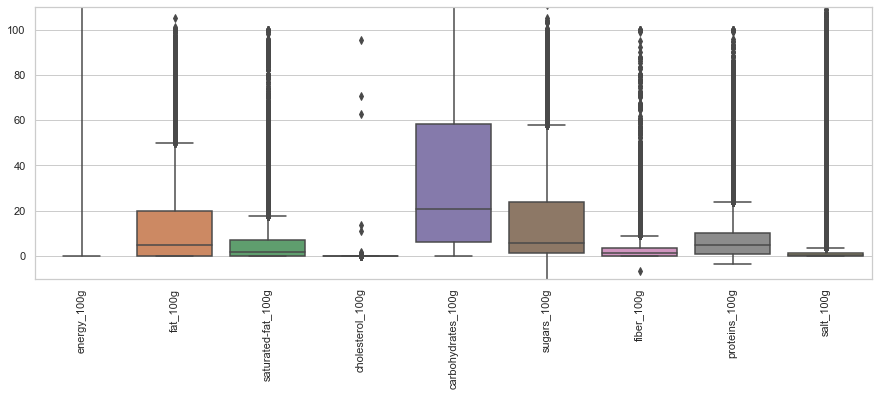

In [33]:
fig = plt.figure(figsize=(15, 5))
ax = plt.axes()
plt.xticks(rotation=90)
ax.set_ylim([-10,110])
sns.boxplot(data=food_facts[slct_ingr])

<AxesSubplot:xlabel='energy_100g'>

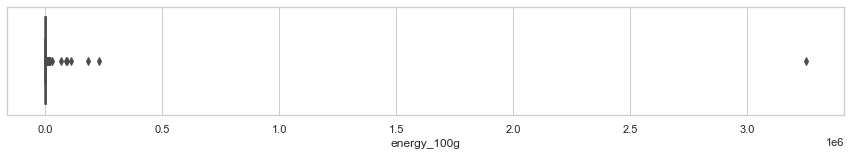

In [34]:
fig = plt.figure(figsize=(15, 2))
sns.boxplot(x=food_facts['energy_100g'])

In [35]:
food_facts.isna().sum().sum()

1504575

## Méthode 1: 
***
     * Pour remplacer les valeurs inférieur à 0 et supérieur aux seuils 4000 pour l'énergie et 
     100g pour le reste des variable nutrition par des NaN 
****

In [36]:
for col in food_facts[slct_ingr].columns:
    if col == "energy_100g": seuil = 3800
    elif col == "cholesterol_100g": seuil = 3.1
    else: seuil = 100
    if food_facts[col].dtypes != 'object':
        for i in food_facts.index:
            val = food_facts[col].iloc[i]
            if val < 0 or val> seuil :
                #print(val)
                food_facts.at[i, col] = np.nan

In [37]:
food_facts.describe()

,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,260756.000000,243887.000000,229551.000000,144085.000000,243569.000000,244952.000000,200881.000000,259918.000000,255352.000000,221210.000000
mean,1121.543927,12.725256,5.125925,0.018316,32.055323,15.985449,2.832473,7.079409,1.588497,9.165535
std,792.520980,17.503695,7.913684,0.038483,29.140680,21.165362,4.588272,8.156552,6.242531,9.055903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,375.000000,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,1.000000
50%,1100.000000,5.000000,1.790000,0.000000,20.600000,5.710000,1.500000,4.760000,0.580000,10.000000
75%,1674.000000,20.000000,7.140000,0.020000,58.330000,24.000000,3.600000,10.000000,1.371600,16.000000
max,3776.000000,100.000000,100.000000,1.580000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000


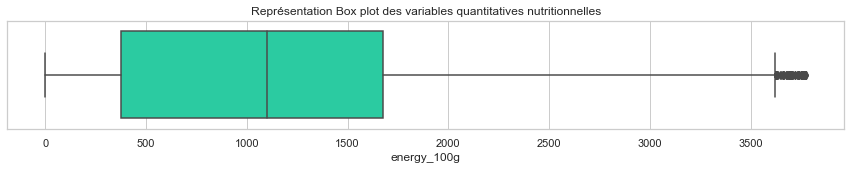

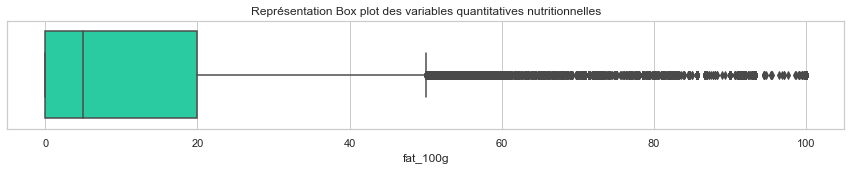

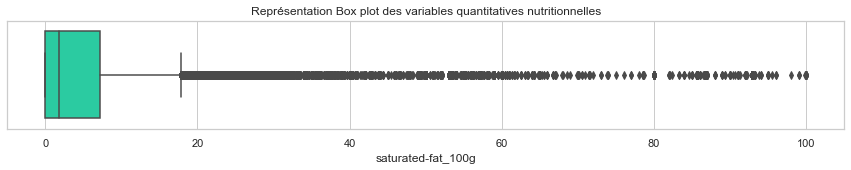

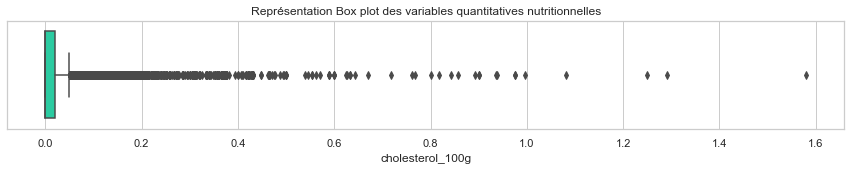

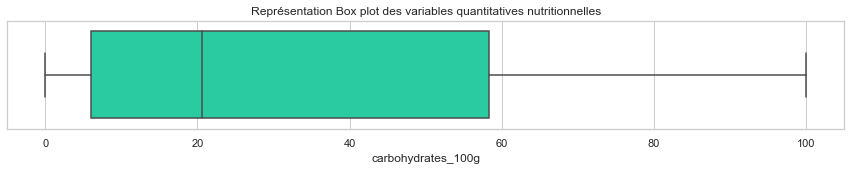

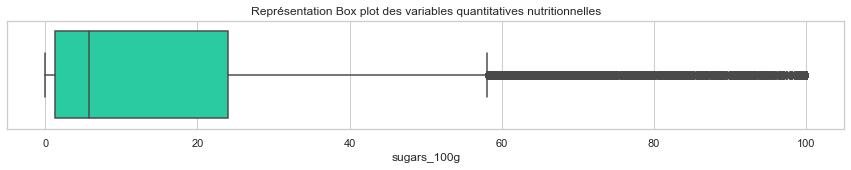

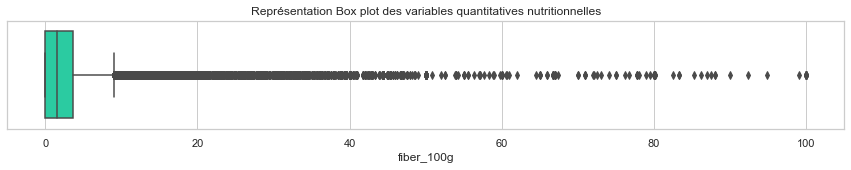

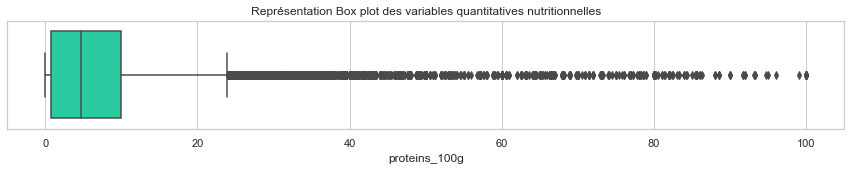

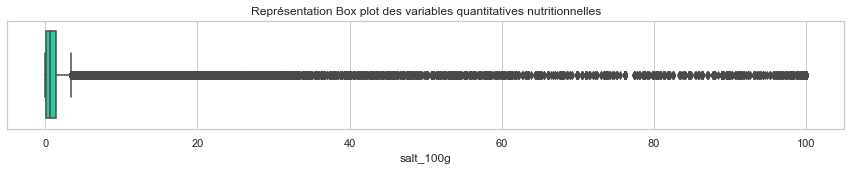

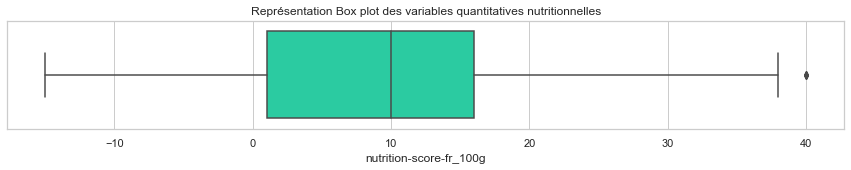

In [38]:

for col in food_facts[slct_ingr_1].columns:
    fig = plt.figure(figsize=(15, 2))
    sns.boxplot(x=food_facts[col], color='#11E5AD').set_title('Représentation Box plot des variables quantitatives nutritionnelles')


*****
     * on constate que toutes les nutritions maintenant n'ont pas de valeurs négatives sauf 
    le nutrition score qui est normal car le nutri grade A contient des valeurs négatives
*****

## Méthode 2: 
****
     * Pour remplacer les valeurs inférieur à 0 et supérieur aux seuils 4000 pour l'énergie et 100g pour le reste des variable nutrition par des NaN méthode "apply"
****

In [39]:

def min_max(df):
    for col in df.columns:
        if col == "energy_100g": seuil = 4000       # le max q'on peut avoir dans 100g de nutrition
        elif col == "cholesterol_100g": seuil = 3.1 # le max q'on peut avoir dans 100g de nutrition
        else: seuil = 100
        if df[col].dtypes != 'object':
            df[col] = df[col].apply(lambda x : np.nan if x < 0 or x > seuil  else x)
    return df
    

In [40]:
%timeit min_max(food_facts[slct_ingr])

<ipython-input-39-04f56baf95f9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x : np.nan if x < 0 or x > seuil  else x)


1 s ± 38.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
food_facts.describe()

,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,260756.000000,243887.000000,229551.000000,144085.000000,243569.000000,244952.000000,200881.000000,259918.000000,255352.000000,221210.000000
mean,1121.543927,12.725256,5.125925,0.018316,32.055323,15.985449,2.832473,7.079409,1.588497,9.165535
std,792.520980,17.503695,7.913684,0.038483,29.140680,21.165362,4.588272,8.156552,6.242531,9.055903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,375.000000,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,1.000000
50%,1100.000000,5.000000,1.790000,0.000000,20.600000,5.710000,1.500000,4.760000,0.580000,10.000000
75%,1674.000000,20.000000,7.140000,0.020000,58.330000,24.000000,3.600000,10.000000,1.371600,16.000000
max,3776.000000,100.000000,100.000000,1.580000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000


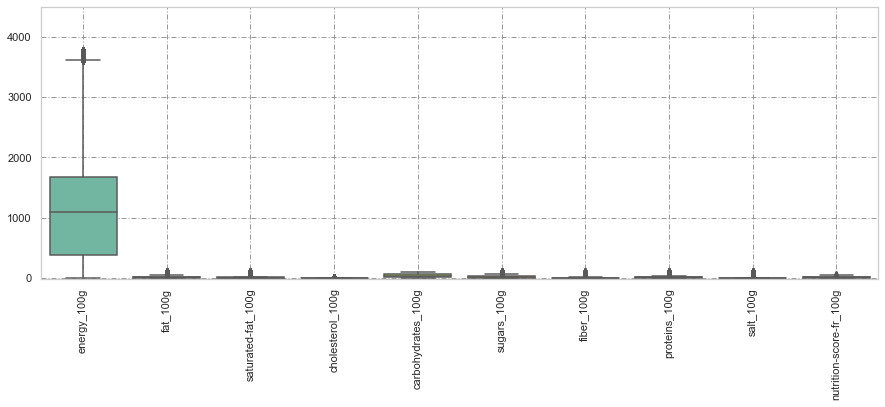

In [42]:
fig = plt.figure(figsize=(15, 5))
ax = plt.axes()
plt.xticks(rotation=90)
ax.set_ylim([-20,4500])
sns.boxplot(data = food_facts, palette="Set2")
plt.grid(True, color='0.6', dashes=(5,2,1,2))

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## Suppréssion des lignes dupliquées

In [43]:
food_facts[food_facts.duplicated() == True].shape[0]

2

In [44]:
food_facts = food_facts.drop_duplicates()
food_facts[food_facts.duplicated() == True].shape[0]

0

## Suppréssion des lignes dupliquées en fonction des variables 

* "code","product_name", "brands","nutrition_grade_fr","nutrition-score-fr_100g

In [45]:
food_facts[food_facts.duplicated(subset = ['code','product_name', 'brands','nutrition_grade_fr','nutrition-score-fr_100g']) == True].shape[0]

17

In [46]:
food_facts = food_facts.drop_duplicates(subset = ["code","product_name", "brands","nutrition_grade_fr","nutrition-score-fr_100g"])
print(food_facts[food_facts.duplicated() == True].shape[0])

0


In [47]:
food_facts.shape

(320753, 19)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## Suppréssion des lignes entièrement NaN:
****

     * Cela concerne les variables nitrutions sélectionnées, en dessous on constate que le dataset food_facts est passé de 320753 lignes à 262744
        * de 74.7% de données ----> à 84.0% de données
****

In [48]:
food_facts.shape

(320753, 19)

* Nombre de colonnes sans NaN -------: 0
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 19
* Nombre de lignes -----------------------: 320753
* Nombre de colonnes ---------------------: 19
* Nombre de cases ------------------------: 6094307
* Nombre de valeurs nulles ---------------: 1504873
* Nombre de valeurs non nulles -----------: 4589434
* le pourcentage des valeurs nulles ------: 24.7 %
* le pourcentage des valeurs non nulles --: 75.3 %


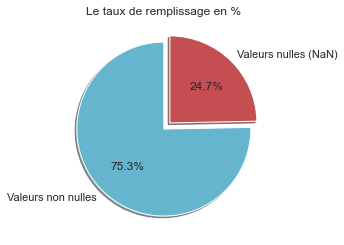

In [49]:
calc_inf(food_facts, False)

In [50]:
food_facts = food_facts.dropna(how='all', subset = slct_ingr)

* Nombre de colonnes sans NaN -------: 1
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 18
* Nombre de lignes -----------------------: 262560
* Nombre de colonnes ---------------------: 19
* Nombre de cases ------------------------: 4988640
* Nombre de valeurs nulles ---------------: 760346
* Nombre de valeurs non nulles -----------: 4228294
* le pourcentage des valeurs nulles ------: 15.2 %
* le pourcentage des valeurs non nulles --: 84.8 %


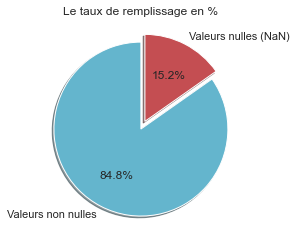

In [51]:
calc_inf(food_facts, False)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  Remplacement des valeurs NaN par la moyenne:
****
     * de chaque sous catégorie pnns_groups_2 on remplace les NaN par la moyenne


     * Si la moyenne de chaque sous catégorie de produit est différent de NaN on remplce la 
     valeur Nan de chaque produit par la moyenne
  ****

In [52]:
food_facts

,code,creator,created_datetime,product_name,brands,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
1,0000000004530,usda-ndb-im...,2017-03-09T...,Banana Chip...,NaN,États-Unis,d,NaN,NaN,2243.0,28.57,28.57,0.018,64.29,14.29,3.6,3.57,0.00000,14.0
2,0000000004559,usda-ndb-im...,2017-03-09T...,Peanuts,Torn & Glasser,États-Unis,b,NaN,NaN,1941.0,17.86,0.00,0.000,60.71,17.86,7.1,17.86,0.63500,0.0
3,0000000016087,usda-ndb-im...,2017-03-09T...,Organic Sal...,Grizzlies,États-Unis,d,NaN,NaN,2540.0,57.14,5.36,NaN,17.86,3.57,7.1,17.86,1.22428,12.0
4,0000000016094,usda-ndb-im...,2017-03-09T...,Organic Pol...,Bob's Red Mill,États-Unis,NaN,NaN,NaN,1552.0,1.43,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN
5,0000000016100,usda-ndb-im...,2017-03-09T...,Breadshop H...,Unfi,États-Unis,NaN,NaN,NaN,1933.0,18.27,1.92,NaN,63.46,11.54,7.7,13.46,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320756,989898,openfoodfac...,2016-09-12T...,Test NF App,NaN,Suisse,NaN,NaN,NaN,569.0,31.00,NaN,NaN,12.20,9.60,1.1,2.10,1.10000,NaN
320757,9900000000233,kiliweb,2017-04-01T...,Amandes,Biosic,France,b,NaN,NaN,2406.0,NaN,3.73,NaN,NaN,3.89,12.2,21.22,0.10000,0.0
320763,99111250,balooval,2013-04-28T...,Thé vert Ea...,Lobodis,France,c,Beverages,Non-sugared...,21.0,0.20,0.20,NaN,0.50,0.50,0.2,0.50,0.02540,2.0
320768,99567453,usda-ndb-im...,2017-03-09T...,Mint Melang...,Trader Joe's,États-Unis,b,NaN,NaN,0.0,0.00,0.00,0.000,0.00,0.00,0.0,0.00,0.00000,0.0


In [53]:
food_facts.isnull().sum()

code                            1
creator                         0
created_datetime                1
product_name                 3366
brands                       6078
countries_fr                   70
nutrition_grade_fr          41541
pnns_groups_1              193924
pnns_groups_2              193720
energy_100g                  1804
fat_100g                    18673
saturated-fat_100g          33009
cholesterol_100g           118475
carbohydrates_100g          18991
sugars_100g                 17608
fiber_100g                  61679
proteins_100g                2657
salt_100g                    7208
nutrition-score-fr_100g     41541
dtype: int64

****
     * Correction des noms de catégories 'pnns_groups_1'et'pnns_groups_2' et remplacer les 'NaN' 
     et 'Unknown' par 'To Define'
****

In [54]:
cols = ['pnns_groups_1','pnns_groups_2']
for col in food_facts[cols].columns:
    food_facts[col] = food_facts[col].fillna('To Define')
    food_facts[col] = food_facts[col].replace(to_replace = "unknown", value = 'To Define')
    # remplacer les 'NaN' et 'Unknown' par 'To Define'
    
    food_facts[col] = food_facts[col].apply(lambda x : x.title() if x != 0 else x)
    # Mettre les catégories 'pnns_groups_1'et'pnns_groups_2' en Majuscule
    
    food_facts[col] = food_facts[col].replace(to_replace = "Sugary-Snacks", value = 'Sugary Snacks')
    food_facts[col] = food_facts[col].replace(to_replace = "sugary-snacks", value = 'Sugary snacks')
    food_facts[col] = food_facts[col].replace(to_replace = "Salty-Snacks", value = 'Salty Snacks')
    food_facts[col] = food_facts[col].replace(to_replace = "Cereals-And-Potatoes", value = 'Cereals And Potatoes')
    food_facts[col] = food_facts[col].replace(to_replace = "Fruits-And-Vegetables", value = 'Fruits And Vegetables')
    # Remplacer les catégories avec (-)

In [55]:
food_facts[food_facts.pnns_groups_1 == "unknown"]

,code,creator,created_datetime,product_name,brands,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g


In [56]:
categories = food_facts['pnns_groups_2'].unique()
categories

array(['To Define', 'Vegetables', 'Biscuits And Cakes',
       'Pizza Pies And Quiche', 'Meat', 'Sweets', 'Sweetened Beverages',
       'Dressings And Sauces', 'One-Dish Meals', 'Soups', 'Cereals',
       'Fruits', 'Milk And Yogurt', 'Fats', 'Non-Sugared Beverages',
       'Cheese', 'Chocolate Products', 'Sandwich', 'Bread', 'Nuts',
       'Legumes', 'Breakfast Cereals', 'Appetizers',
       'Artificially Sweetened Beverages', 'Fruit Juices', 'Eggs',
       'Fish And Seafood', 'Dried Fruits', 'Ice Cream', 'Processed Meat',
       'Potatoes', 'Pastries', 'Dairy Desserts', 'Alcoholic Beverages',
       'Fruit Nectars', 'Salty And Fatty Products', 'Tripe Dishes'],
      dtype=object)

In [57]:
categories.shape

(37,)

In [58]:
var = food_facts.groupby(['pnns_groups_1','pnns_groups_2']).mean(numeric_only=True)
var

energy_100g   fat_100g  saturated-fat_100g  \
pnns_groups_1   pnns_groups_2                                                 
Beverages       Artificially...    94.547569   0.119411        0.042833       
                Fruit Juices      200.121100   0.150086        0.047444       
                Fruit Nectars     195.941033   0.138602        0.030993       
                Non-Sugared ...   277.628553   1.852766        1.092163       
                Sweetened Be...   345.542915   0.602772        0.453699       
Cereals And ... Bread            1352.289544   5.879836        1.383543       
                Breakfast Ce...  1676.778049   8.686106        2.728378       
                Cereals          1347.875637   4.543233        1.472926       
                Legumes           951.792706   9.421981        1.765516       
                Potatoes          504.731183   4.372630        1.587174       
Composite Foods One-Dish Meals    619.614751   6.895619        2.182138       
                Pizza Pies A...   976.650108   9.874576        4.895485       
                Sandwich         1020.144384  10.713213        3.602833       
Fat And Sauces  Dressings An...   937.858129  18.624654        2.438727       
                Fats             3036.872708  81.841839       30.305257       
Fish Meat Eggs  Eggs              602.891243  10.189290        2.749873       
                Fish And Sea...   766.293726  11.237969        2.240294       
                Meat              708.055234   9.211751        3.323891       
                Processed Meat   1024.986767  17.900280        6.867721       
Fruits And V... Dried Fruits     1461.234719  10.205966        2.593177       
                Fruits            431.284308   1.696555        1.129188       
                Soups             220.308639   1.941839        0.724900       
                Vegetables        242.176587   1.655613        0.317405       
Milk And Dai... Cheese           1190.204876  23.209557       15.596757       
                Dairy Desserts    645.370166   6.546950        4.261420       
                Ice Cream         912.346345  10.755539        7.369065       
                Milk And Yogurt   415.096259   5.355778        3.490884       
Salty Snacks    Appetizers       2018.729076  25.850587        5.154375       
                Nuts             2456.695599  48.356377        6.953989       
                Salty And Fa...  1880.315789  21.250000        6.135263       
Sugary Snacks   Biscuits And...  1875.424461  19.861366        9.433683       
                Chocolate Pr...  2173.514339  32.591509       18.729521       
                Pastries         1529.029851  14.203534        7.494015       
                Sweets           1488.107818  10.116238        3.958470       
To Define       Alcoholic Be...   369.877973   1.259286        0.607742       
                To Define        1130.798836  12.505408        5.041665       
                Tripe Dishes      716.714286  11.789583        4.826042       

                                 cholesterol_100g  carbohydrates_100g  \
pnns_groups_1   pnns_groups_2                                           
Beverages       Artificially...        0.000000          4.874936       
                Fruit Juices           0.000000         10.838720       
                Fruit Nectars               NaN         10.890927       
                Non-Sugared ...        0.000786         10.576342       
                Sweetened Be...        0.003565         18.558669       
Cereals And ... Bread                  0.001403         55.440532       
                Breakfast Ce...        0.000000         68.569825       
                Cereals                0.003211         58.259114       
                Legumes                0.000106         19.484800       
                Potatoes               0.003000         18.188710       
Composite Foods One-Dish Meals         0.007369         13.642660       
  

In [59]:
food_facts

,code,creator,created_datetime,product_name,brands,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
1,0000000004530,usda-ndb-im...,2017-03-09T...,Banana Chip...,NaN,États-Unis,d,To Define,To Define,2243.0,28.57,28.57,0.018,64.29,14.29,3.6,3.57,0.00000,14.0
2,0000000004559,usda-ndb-im...,2017-03-09T...,Peanuts,Torn & Glasser,États-Unis,b,To Define,To Define,1941.0,17.86,0.00,0.000,60.71,17.86,7.1,17.86,0.63500,0.0
3,0000000016087,usda-ndb-im...,2017-03-09T...,Organic Sal...,Grizzlies,États-Unis,d,To Define,To Define,2540.0,57.14,5.36,NaN,17.86,3.57,7.1,17.86,1.22428,12.0
4,0000000016094,usda-ndb-im...,2017-03-09T...,Organic Pol...,Bob's Red Mill,États-Unis,NaN,To Define,To Define,1552.0,1.43,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN
5,0000000016100,usda-ndb-im...,2017-03-09T...,Breadshop H...,Unfi,États-Unis,NaN,To Define,To Define,1933.0,18.27,1.92,NaN,63.46,11.54,7.7,13.46,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320756,989898,openfoodfac...,2016-09-12T...,Test NF App,NaN,Suisse,NaN,To Define,To Define,569.0,31.00,NaN,NaN,12.20,9.60,1.1,2.10,1.10000,NaN
320757,9900000000233,kiliweb,2017-04-01T...,Amandes,Biosic,France,b,To Define,To Define,2406.0,NaN,3.73,NaN,NaN,3.89,12.2,21.22,0.10000,0.0
320763,99111250,balooval,2013-04-28T...,Thé vert Ea...,Lobodis,France,c,Beverages,Non-Sugared...,21.0,0.20,0.20,NaN,0.50,0.50,0.2,0.50,0.02540,2.0
320768,99567453,usda-ndb-im...,2017-03-09T...,Mint Melang...,Trader Joe's,États-Unis,b,To Define,To Define,0.0,0.00,0.00,0.000,0.00,0.00,0.0,0.00,0.00000,0.0


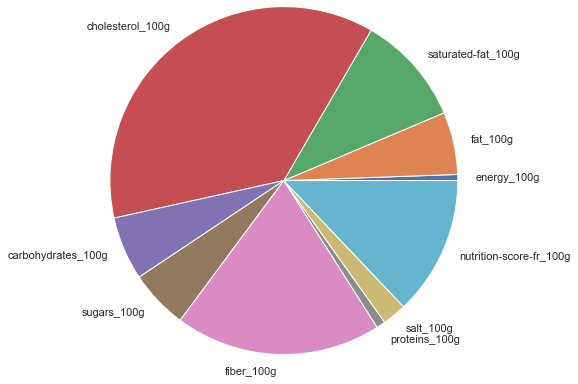

In [60]:

y = pd.DataFrame(food_facts[slct_ingr_1].isna().sum())
mylabels = ['energy_100g', 'fat_100g','saturated-fat_100g','cholesterol_100g','carbohydrates_100g','sugars_100g', 
            'fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']

plt.pie(y[0], labels = mylabels,explode=None, colors=None, autopct=None, pctdistance=1, 
        shadow=False, labeldistance=1.1, startangle=0, radius=2, normalize=True)
plt.plot('fffff')
#plt.legend(loc = 'upper right')
plt.show() 

  *****
    * Après le remplacement les NaNs par 'To Define' pour les deux catégories pnns_groups_2 
    et pnns_groups_1 qui présentaient plus de 7.8%  car on est passé de 15% à 7% de NaNs, 
    comme illustré en Pie en dessous.
****

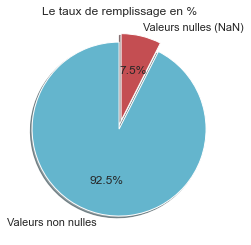

In [61]:
pie_pc(food_facts)

* Remplacer les NaN par la moyenne si le score est supérieur ou égale au seuil 0

In [62]:
threshold = 0
for cat in categories:
    y = food_facts.pnns_groups_2 == cat 
    for col in food_facts[y][slct_ingr_1].columns:
    #
        mean_val = food_facts[food_facts['pnns_groups_2'] == cat][col].mean()
        std_val = food_facts[food_facts['pnns_groups_2'] == cat][col].std()
        if not np.isnan(mean_val) and std_val!= 0:
            score = float(mean_val/std_val)
            #print(std_val)
            if score >= threshold:
                food_facts[col][y]= food_facts[col][y].apply(lambda x : mean_val if np.isnan(x) else x)

<ipython-input-62-648adf2b668b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_facts[col][y]= food_facts[col][y].apply(lambda x : mean_val if np.isnan(x) else x)


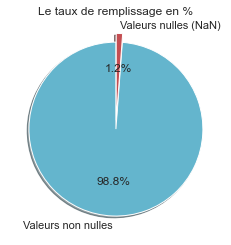

In [63]:
pie_pc(food_facts)

In [64]:
food_facts[slct_ingr_1].isnull().sum()

energy_100g                   0
fat_100g                      0
saturated-fat_100g            0
cholesterol_100g           6596
carbohydrates_100g            0
sugars_100g                   0
fiber_100g                    0
proteins_100g                 0
salt_100g                     0
nutrition-score-fr_100g    1013
dtype: int64

     * On remarque qu'il reste que le 'cholesterol_100g' avec des NaNs car la moyenne de cette variable dans plusieurs cat produit égale à NaN, dans ce cas on remplace par la moyenne de la variable même.

In [65]:
mean_val = food_facts["cholesterol_100g"].mean()
mean_val

0.019019343349600103

In [66]:
food_facts["cholesterol_100g"] = food_facts["cholesterol_100g"].fillna(mean_val)

In [67]:
food_facts[slct_ingr_1].isnull().sum()

energy_100g                   0
fat_100g                      0
saturated-fat_100g            0
cholesterol_100g              0
carbohydrates_100g            0
sugars_100g                   0
fiber_100g                    0
proteins_100g                 0
salt_100g                     0
nutrition-score-fr_100g    1013
dtype: int64

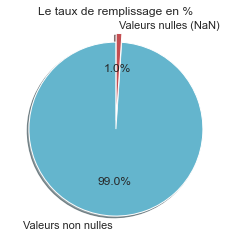

In [68]:
pie_pc(food_facts)

##### Pour le 1% des NaNs qui reste on va le supprimer 

In [69]:
food_facts = food_facts.dropna()

* Nombre de colonnes sans NaN -------: 19
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de lignes -----------------------: 215764
* Nombre de colonnes ---------------------: 19
* Nombre de cases ------------------------: 4099516
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 4099516
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


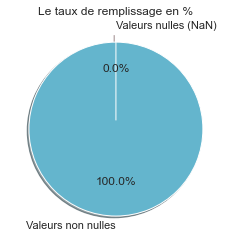

In [70]:
calc_inf(food_facts, False)

****
     * En dessous on crée un dictionnaire qui contient les noms des catégories pnns1 et pnns2 pour remplacer 'To Define' aux produits non définis, cela concerne presque 3500 produits
*****

In [71]:
food_facts["product_name"].value_counts()[0 : 150]

Ice Cream                          409
Potato Chips                       276
Premium Ice Cream                  226
Pinto Beans                        160
Beef Jerky                         159
Cookies                            154
Popcorn                            145
Cut Green Beans                    136
Salsa                              135
Tomato Sauce                       134
Creamy Peanut Butter               126
Black Beans                        125
Tomato Ketchup                     123
Tortilla Chips                     120
Milk Chocolate                     117
Pasta Sauce                        108
Chicken Broth                      107
2% Reduced Fat Milk                106
Cottage Cheese                     105
Protein Bar                        101
Trail Mix                           99
Spaghetti                           93
Granola                             93
Diced Tomatoes                      91
Raw Shrimp                          90
Sharp Cheddar Cheese     

In [72]:
food_facts[food_facts["product_name"] == "Sauce"]

,code,creator,created_datetime,product_name,brands,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
9416,0011246248835,usda-ndb-im...,2017-03-09T...,Sauce,Robert's Re...,États-Unis,d,To Define,To Define,812.0,0.000000,0.00,0.000000,47.220000,44.44,0.000000,0.00,0.00000,11.0
9461,0011246667834,usda-ndb-im...,2017-03-09T...,Sauce,Robert Roth...,États-Unis,d,To Define,To Define,812.0,0.000000,0.00,0.000000,47.220000,44.44,0.000000,0.00,0.00000,11.0
20580,0023933930879,usda-ndb-im...,2017-03-09T...,Sauce,"Signature, ...",États-Unis,d,To Define,To Define,699.0,0.000000,0.00,0.000000,38.890000,27.78,0.000000,0.00,3.24612,18.0
31657,0036200004425,usda-ndb-im...,2017-03-09T...,Sauce,Ragu,États-Unis,b,To Define,To Define,293.0,1.950000,0.00,0.000000,11.720000,7.81,1.600000,1.56,0.91186,2.0
31659,0036200004456,usda-ndb-im...,2017-03-09T...,Sauce,R&B Foods Inc,États-Unis,c,To Define,To Define,293.0,1.560000,0.00,0.000000,12.500000,8.59,1.600000,1.56,0.93218,3.0
31663,0036200004685,usda-ndb-im...,2017-03-09T...,Sauce,R&B Foods Inc,États-Unis,c,To Define,To Define,293.0,2.710000,0.39,0.000000,10.850000,6.98,1.600000,1.55,0.94488,3.0
31679,0036200015100,usda-ndb-im...,2017-03-09T...,Sauce,R&B Foods Inc.,États-Unis,c,To Define,To Define,293.0,1.940000,0.00,0.000000,10.850000,6.98,1.600000,1.55,0.94488,3.0
31683,0036200018606,usda-ndb-im...,2017-03-09T...,Sauce,R&B Foods Inc.,États-Unis,c,To Define,To Define,293.0,1.560000,0.00,0.000000,12.500000,9.38,1.600000,1.56,0.91186,3.0
31696,0036200219225,usda-ndb-im...,2017-03-10T...,Sauce,"Bertolli, ...",États-Unis,c,To Define,To Define,335.0,2.800000,0.80,0.004000,11.200000,10.40,0.800000,3.20,1.05664,4.0
31716,0036200378168,usda-ndb-im...,2017-03-09T...,Sauce,Ragu,États-Unis,c,To Define,To Define,234.0,1.200000,0.00,0.004000,9.600000,5.60,1.600000,1.60,0.97536,3.0


In [73]:
diction = {'Ice Cream' :              ['Ice Cream', 'Milk And Dairy Products'],
            'Extra Virgin Olive Oil': ['Fats', 'Fat And Sauces'],
            'Potato Chips':           ['Salty And Fatty Products', 'Salty Snacks'],
            'Premium Ice Cream':      ['Ice Cream', 'Milk And Dairy Products'],
            'Tomato Ketchup':         ['Dressings And Sauces', 'Fat And Sauces'],
            'Beef Jerky':             ['Processed Meat', 'Fish Meat Eggs'],
            'Pinto Beans':            ['Legumes', 'Cereals And Potatoes'],
            'Cookies':                ['Biscuits And Cakes','Sugary Snacks'],
            'Popcorn':                ['Cereals', 'Cereals And Aotatoes'], 
            'Salsa':                  ['Dressings And Sauces', 'Fat And Sauces'],
            'Tomato Sauce':           ['Dressings And Sauces', 'Fat And Sauces'],
            'Cut Green Beans':        ['Legumes', 'Cereals And Potatoes'],
            'Black Beans':            ['Legumes', 'Cereals And Potatoes'],
            'Creamy Peanut Butter':   ['Legumes', 'Cereals And Potatoes'],
            'Tortilla Chips':         ['Appetizers','Salty Snacks'],
            'Apple Sauce':            ['Dressings And Sauces', 'Fat And Sauces'],
            'Candy':                  ['Sweets', 'Sugary Snacks'],
            'Milk Chocolate':         ['Chocolate Products', 'Sugary Snacks'],
            'Pasta Sauce':            ['Dressings And Sauces', 'Fat And Sauces'],
            'Chicken Broth':          ['Processed Meat', 'Fish Meat Eggs'],
            'Cottage Cheese':         ['Cheese', 'Milk And Dairy Products'],
            '2% Reduced Fat Milk':    ['Milk And Yogurt', 'Milk And Dairy Products'],
            'Greek Nonfat Yogurt':    ['Milk And Yogurt', 'Milk And Dairy Products'],
            'Soda':                   ['Sweetened Beverages', 'Beverages'],
            'Real Mayonnaise':        ['Dressings And Sauces', 'Fat And Sauces'],
            'Protein Bar':            ['Processed Meat', 'Fish Meat Eggs'],
            'Spaghetti':              ['Cereals', 'cereals And Potatoes'],
            'Diced Tomatoes':         ['Soups', 'Fruits And Vegetables'],
            'Trail Mix':              ['Nuts','Salty Snacks'],
            'Hot Sauce':              ['Dressings And Sauces', 'Fat And Sauces'],
            'Granola':                ['Biscuits And Cakes', 'Sugary Snacks'],
            'Mixed Vegetables':       ['Vegetables', 'fruits And Vegetables'],
            'Sharp Cheddar Cheese':   ['Cheese', 'Milk And Dairy Products'],
            'Sweet Peas':             ['Legumes', 'cereals And Potatoes'],
            'Raw Shrimp':             ['Fish And Seafood', 'Fish Meat Eggs'],
            'Cola':                   ['Sweetened Beverages', 'Beverages'],
            'Almonds':                ['Nuts','Salty Snacks'],
            'Honey':                  ['Sweets', 'Sugary Snacks'],
            'Dark Chocolate':         ['Chocolate Products', 'Sugary Snacks'],
            'Frosted Sugar Cookies':  ['Biscuits And Cakes','Sugary Snacks'],
            'Chunk Light Tuna In Water':['Processed Meat', 'Fish Meat Eggs'],
            'Bbq Sauce':              ['Dressings And Sauces', 'Fat And Sauces'],
            'Sparkling Water':        ['Non-Sugared Beverages', 'Beverages'],
            'Gelato':                 ['Ice Cream', 'Milk And Dairy Products'],
            'Barbecue Sauce':         ['Dressings And Sauces', 'Fat And Sauces'],
            'Tomato Paste':           ['Dressings And Sauces', 'Fat And Sauces'],
            'Fat Free Milk':          ['Milk And Yogurt', 'Milk And Dairy Products'],
            'Green Tea':              ['Non-Sugared Beverages', 'Beverages'],
            'Vegetable Oil':          ['Fats', 'Fat And Sauces'],
            'Crunchy Peanut Butter':  ['Sweets', 'Sugary Snacks'],
            'Greek Yogurt':           ['Milk And Yogurt', 'Milk And Dairy Products'],
            'Mixed Nuts':             ['Nuts','Salty Snacks'],
            'Yellow Mustard':         ['Dressings And Sauces', 'Fat And Sauces'],
            'Mozzarella Cheese':      ['Cheese', 'Milk And Dairy Products'],
            'Mayonnaise':             ['Dressings And Sauces', 'Fat And Sauces'],
            'Smoked Sausage':         ['Dressings And Sauces', 'Fat And Sauces'],
            'Great Northern Beans':   ['Vegetables', 'Fruits And Vegetables'],
            'Canola Oil':             ['Fats', 'Fat And Sauces'],
            'Cooked Shrimp':          ['Fish And Seafood', 'Fish Meat Eggs'],
            'Applesauce':             ['Fats', 'Fat And Sauces'],
            'Lemonade':               ['Sweetened Beverages', 'Beverages'],
            'Sauce':                  ['Dressings And Sauces', 'Fat And Sauces']}
      

In [74]:
food_facts['pnns_groups_1'].value_counts()

To Define                  165763
Sugary Snacks                9880
Milk And Dairy Products      6798
Cereals And Potatoes         6733
Composite Foods              5561
Beverages                    5558
Fish Meat Eggs               5314
Fruits And Vegetables        4148
Fat And Sauces               3677
Salty Snacks                 2332
Name: pnns_groups_1, dtype: int64

#####  Définir les catégories produits par le dictionnaire prédéfini

In [75]:
col_1 = ['pnns_groups_1']
col_2 = ['pnns_groups_2']
for k , v in diction.items():
    if k in diction:
        y = food_facts.product_name == k
        #  v = ['pnns_groups_1', 'pnns_groups_2']
        b = v[0]        # ['Milk and dairy products']
        a = v[1]        # ['Ice Cream']
        #print(k, a,b)
        for index in food_facts[y].index:  #[col]
            food_facts.at[index,col_1] = a
            food_facts.at[index,col_2] = b

C:\Users\Win\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [76]:
food_facts['pnns_groups_1'].value_counts()

To Define                  160298
Sugary Snacks               10567
Milk And Dairy Products      8113
Cereals And Potatoes         7229
Fish Meat Eggs               5903
Beverages                    5601
Composite Foods              5561
Fat And Sauces               4794
Fruits And Vegetables        4306
Salty Snacks                 2984
cereals And Potatoes          179
Cereals And Aotatoes          145
fruits And Vegetables          84
Name: pnns_groups_1, dtype: int64

In [77]:
y = food_facts.product_name == "Sauce"
food_facts[y]

,code,creator,created_datetime,product_name,brands,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
9416,0011246248835,usda-ndb-im...,2017-03-09T...,Sauce,Robert's Re...,États-Unis,d,Fat And Sauces,Dressings A...,812.0,0.000000,0.00,0.000000,47.220000,44.44,0.000000,0.00,0.00000,11.0
9461,0011246667834,usda-ndb-im...,2017-03-09T...,Sauce,Robert Roth...,États-Unis,d,Fat And Sauces,Dressings A...,812.0,0.000000,0.00,0.000000,47.220000,44.44,0.000000,0.00,0.00000,11.0
20580,0023933930879,usda-ndb-im...,2017-03-09T...,Sauce,"Signature, ...",États-Unis,d,Fat And Sauces,Dressings A...,699.0,0.000000,0.00,0.000000,38.890000,27.78,0.000000,0.00,3.24612,18.0
31657,0036200004425,usda-ndb-im...,2017-03-09T...,Sauce,Ragu,États-Unis,b,Fat And Sauces,Dressings A...,293.0,1.950000,0.00,0.000000,11.720000,7.81,1.600000,1.56,0.91186,2.0
31659,0036200004456,usda-ndb-im...,2017-03-09T...,Sauce,R&B Foods Inc,États-Unis,c,Fat And Sauces,Dressings A...,293.0,1.560000,0.00,0.000000,12.500000,8.59,1.600000,1.56,0.93218,3.0
31663,0036200004685,usda-ndb-im...,2017-03-09T...,Sauce,R&B Foods Inc,États-Unis,c,Fat And Sauces,Dressings A...,293.0,2.710000,0.39,0.000000,10.850000,6.98,1.600000,1.55,0.94488,3.0
31679,0036200015100,usda-ndb-im...,2017-03-09T...,Sauce,R&B Foods Inc.,États-Unis,c,Fat And Sauces,Dressings A...,293.0,1.940000,0.00,0.000000,10.850000,6.98,1.600000,1.55,0.94488,3.0
31683,0036200018606,usda-ndb-im...,2017-03-09T...,Sauce,R&B Foods Inc.,États-Unis,c,Fat And Sauces,Dressings A...,293.0,1.560000,0.00,0.000000,12.500000,9.38,1.600000,1.56,0.91186,3.0
31696,0036200219225,usda-ndb-im...,2017-03-10T...,Sauce,"Bertolli, ...",États-Unis,c,Fat And Sauces,Dressings A...,335.0,2.800000,0.80,0.004000,11.200000,10.40,0.800000,3.20,1.05664,4.0
31716,0036200378168,usda-ndb-im...,2017-03-09T...,Sauce,Ragu,États-Unis,c,Fat And Sauces,Dressings A...,234.0,1.200000,0.00,0.004000,9.600000,5.60,1.600000,1.60,0.97536,3.0


****
     * On remarque que malgré les seuils qu'on a pris ( 0 et 100g), on a toujours des valeurs abérrantes comme illustré par exemple l'eau a 100g de protéine ce qui n'est pas normale, donc pour supprimer ces valeurs on utilise la méthode percentile pour les éliminer
*****

In [78]:
food_facts[food_facts['product_name']=='Eau']

,code,creator,created_datetime,product_name,brands,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
232775,3434890000135,kiliweb,2017-03-13T...,Eau,Delhaize,France,c,To Define,To Define,0.0,12.505408,0.0,0.018331,33.357108,0.0,0.0,0.0,1.320,5.0
242506,3564700629185,openfoodfac...,2016-05-30T...,Eau,Marque Repère,France,b,To Define,To Define,0.0,0.000000,0.0,0.018331,0.100000,0.1,0.0,0.0,0.007,0.0
283105,6091035082004,kiliweb,2017-02-21T...,Eau,Vital,France,e,To Define,To Define,418.0,12.505408,100.0,0.018331,33.357108,100.0,100.0,100.0,2.000,24.0


##### Et la méthode describe() nous montre également que sur les valeurs Max on a beacoups de 100g pour plusieurs nutritions 

In [79]:
food_facts.describe()

,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,215764.000000,215764.000000,215764.000000,215764.000000,215764.000000,215764.000000,215764.000000,215764.000000,215764.000000,215764.000000
mean,1175.014447,13.266643,4.952370,0.018464,33.161019,14.981287,2.720174,7.779048,1.239527,9.162242
std,758.249002,15.521867,7.545098,0.031362,27.298674,19.795657,4.236390,8.078766,3.957804,9.052522
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,452.000000,1.110000,0.000000,0.000000,7.800000,1.300000,0.000000,1.900000,0.100000,1.000000
50%,1191.000000,8.930000,1.790000,0.007369,28.570000,5.000000,1.600000,5.700000,0.650000,10.000000
75%,1714.000000,20.180000,7.140000,0.019019,57.140000,23.000000,3.500000,10.710000,1.361440,16.000000
max,3776.000000,100.000000,100.000000,1.580000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000


In [80]:
food_facts_clean = food_facts.copy()

In [81]:
for col in food_facts_clean[slct_ingr].columns:
    if food_facts_clean[col].dtypes != 'object':
        food_facts_clean.loc[food_facts_clean[col] > food_facts_clean[col].quantile(0.999)] = np.nan
        #food_facts.loc[food_facts[col] < 0] = np.nan
food_facts_clean = food_facts_clean.dropna()

In [82]:
food_facts_clean.describe()

,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,214614.000000,214614.000000,214614.000000,214614.000000,214614.000000,214614.000000,214614.000000,214614.000000,214614.000000,214614.000000
mean,1171.895717,13.185933,4.866561,0.018244,33.232691,15.038211,2.671518,7.719618,1.152080,9.153289
std,752.320241,15.277566,7.086464,0.029108,27.300999,19.813287,3.860846,7.775256,2.832935,9.049506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,452.000000,1.110000,0.000000,0.000000,7.920000,1.300000,0.000000,2.000000,0.100000,1.000000
50%,1188.000000,8.930000,1.790000,0.007369,28.570000,5.050000,1.600000,5.700000,0.650240,10.000000
75%,1711.000000,20.100000,7.140000,0.019019,57.140000,23.080000,3.500000,10.710000,1.361440,16.000000
max,3736.000000,100.000000,60.380000,0.356400,100.000000,100.000000,40.800000,60.000000,68.200000,40.000000


In [83]:
food_facts_clean = food_facts_clean.dropna()
food_facts_clean[food_facts_clean['product_name']=='Eau']

,code,creator,created_datetime,product_name,brands,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
232775,3434890000135,kiliweb,2017-03-13T...,Eau,Delhaize,France,c,To Define,To Define,0.0,12.505408,0.0,0.018331,33.357108,0.0,0.0,0.0,1.320,5.0
242506,3564700629185,openfoodfac...,2016-05-30T...,Eau,Marque Repère,France,b,To Define,To Define,0.0,0.000000,0.0,0.018331,0.100000,0.1,0.0,0.0,0.007,0.0


In [84]:
#food_facts_clean['nutrition-score-fr_100g'].max()

<AxesSubplot:>

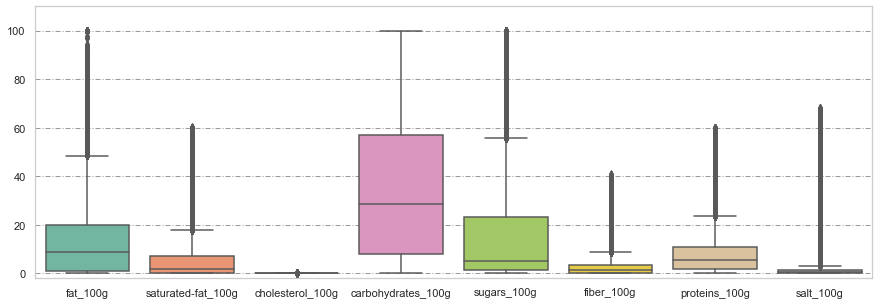

In [85]:
fig = plt.figure(figsize=(15, 5))
ff = food_facts_clean[slct_ingr].drop(columns = ['energy_100g'])
ax = plt.axes()
plt.yticks(rotation=0)

ax.set_ylim([-2,110])
plt.grid(True, color='0.6', dashes=(5,2,1,2))
sns.boxplot(data = ff, palette="Set2")

* Nombre de colonnes sans NaN -------: 19
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de ligne entièrement nulles : 0
* Nombre de ligne mixtes ----------- : 0
* Nombre de ligne sans NaN ----------: 214614
* Nombre de lignes -----------------------: 214614
* Nombre de colonnes ---------------------: 19
* Nombre de cases ------------------------: 4077666
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 4077666
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


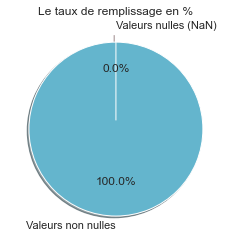

In [86]:
calc_inf(food_facts_clean, True)

In [87]:
 
food_facts_clean.to_csv('D:/Projet Classrooms/Projet_3/food_facts_clean.csv')


#### Après l'enregistrement du Dataset la taille du fichier est passée de 827Mo à 43Mo